In [1]:
# change position of working directory
import os
import sys

module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# import all necessary packages
import pandas as pd
import numpy as np
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from optuna.study import create_study

# import all internal packages
from cross_validation import stratified_cross_validation, validate

/Users/michalzajac/Library/Caches/pypoetry/virtualenvs/mow-QOMKVymr-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# read data
db_path = "../../db/models-data/alpha.csv"
df = pd.read_csv(db_path)

# Select Important Features

In [4]:
# define X and y
X = df.drop(columns=["TARGET"])
Y = df["TARGET"]

# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.1, random_state=42)

# define models
etc = ExtraTreesClassifier(random_state=1, n_jobs=-1)
etc.fit(X_train, Y_train)

# get feature importances
features = []
features_to_drop = []
for ind, value in enumerate(etc.feature_importances_):
    if value > 0.005:
        features.append(X.columns[ind])
    else:
        features_to_drop.append(X.columns[ind])

# drop features
df.drop(columns=features_to_drop, inplace=True)

# displat persisted data
df.columns

Index(['AMT_INCOME_TOTAL', 'TARGET', 'STATUS_0', 'STATUS_1', 'STATUS_2',
       'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_C', 'STATUS_X'],
      dtype='object')

<Axes: >

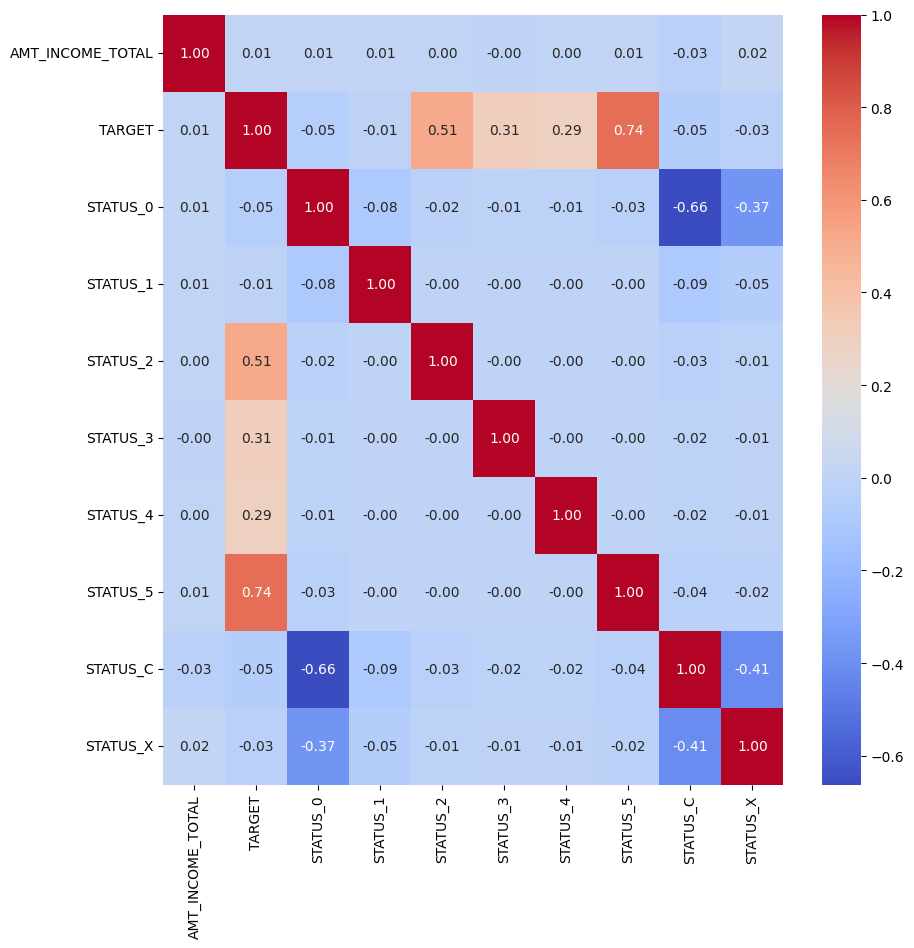

In [5]:
# display correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")

# Optimization

In [6]:
# prepare test and train data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.1, random_state=42)

# define objective function
def objective(trial):
    # define hyperparameters
    rf_booster = trial.suggest_categorical("rf_booster", ['gbtree', 'gblinear', 'dart'])
    rf_eval_metric = trial.suggest_categorical("rf_eval_metric", ['logloss', 'mae', 'mape', 'auc'])

    # prepare classifiers
    xgb = XGBClassifier(eval_metric=rf_eval_metric, booster=rf_booster)
    dtc = DecisionTreeClassifier()

    # create voting classifier
    voting_clf = VotingClassifier(estimators=[('xgb', xgb), ('dtc', dtc)], voting='hard')

    # score the model
    voting_clf.fit(X_train, Y_train)
    acc = voting_clf.score(X_test, Y_test)

    return acc

# create study
study = create_study(direction="maximize")
study.optimize(objective, n_trials=50, n_jobs=4)

# get best hyperparameters
study.best_trial

[I 2023-06-08 18:17:22,077] A new study created in memory with name: no-name-f17cc81c-3da2-4d65-9d40-7c37590aa76c
[I 2023-06-08 18:17:23,409] Trial 2 finished with value: 1.0 and parameters: {'rf_booster': 'gblinear', 'rf_eval_metric': 'logloss'}. Best is trial 2 with value: 1.0.
[I 2023-06-08 18:17:23,448] Trial 3 finished with value: 1.0 and parameters: {'rf_booster': 'gblinear', 'rf_eval_metric': 'auc'}. Best is trial 2 with value: 1.0.
[I 2023-06-08 18:17:26,972] Trial 4 finished with value: 1.0 and parameters: {'rf_booster': 'gbtree', 'rf_eval_metric': 'logloss'}. Best is trial 2 with value: 1.0.
[I 2023-06-08 18:17:30,333] Trial 6 finished with value: 1.0 and parameters: {'rf_booster': 'gbtree', 'rf_eval_metric': 'logloss'}. Best is trial 2 with value: 1.0.
[I 2023-06-08 18:17:33,632] Trial 7 finished with value: 1.0 and parameters: {'rf_booster': 'gbtree', 'rf_eval_metric': 'logloss'}. Best is trial 2 with value: 1.0.
[I 2023-06-08 18:17:36,866] Trial 8 finished with value: 1.0 

FrozenTrial(number=2, state=1, values=[1.0], datetime_start=datetime.datetime(2023, 6, 8, 18, 17, 22, 79637), datetime_complete=datetime.datetime(2023, 6, 8, 18, 17, 23, 409837), params={'rf_booster': 'gblinear', 'rf_eval_metric': 'logloss'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'rf_eval_metric': CategoricalDistribution(choices=('logloss', 'mae', 'mape', 'auc'))}, trial_id=2, value=None)

# Training

In [12]:
# prepare classifiers
xgb = XGBClassifier(eval_metric='logloss', booster='gblinear', n_jobs=4)
dtc = DecisionTreeClassifier()

# create voting classifier
voting_clf = VotingClassifier(estimators=[('xgb', xgb), ('dtc', dtc)], voting='hard')

# prepare cross-validation data
train_test_splits = stratified_cross_validation(df, "TARGET", n_folds=10)

# validate
np.mean(validate(train_test_splits, voting_clf, "TARGET"))

1.0